In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

# functions

In [9]:
# converts only 1D or 2D array
def convert_to_percentage(arr):
    ret = list()

    for row in arr:
        count = 0
        newrow = list()

    for cell in row:
        count = count+cell

    for cell in row:
        newrow.append(cell/count)

    ret.append(newrow)
    return ret

In [10]:
def fix(s):
    firstcolon = s.find(":")
    s_new = s[firstcolon-2:firstcolon] + s[firstcolon+1:firstcolon+3]
    s_new = s_new.replace("*", "0")
    return s_new

def compute_resolution(gs_val,pre_val):
    gs_all = gs_val.split("/")
    pre_fixed = fix(pre_val)
    flag = False #false = inaccurate, turn to true = 2 digits accurate
    
    for val in gs_all:
        gs_fixed = fix(val)

        if (gs_fixed[0:2] == pre_fixed[0:2]):
            if (gs_fixed[2:4] == pre_fixed[2:4]):
                return 4
            flag = True
        
    return 2 if flag==True else 0

In [11]:
# requirements: gs accession numbers are under a column labeled "Run" 
#pre accession numbers are under a column labeled "ERR" 
# accession numbers/column titles are labeled identically between gold standard and results csv
# Only accuracy for samples in both GS and PRE are calculated. Samples in PRE, but not in GS are ignored. Samples in GS, but not in PRE, are tallied in the "failed" variable 
def compute_matches(pre,gs):

    # index 0 is class I, index 1 is class II
    fourdig = [0,0]
    twodig = [0,0]
    zerodig = [0,0]
    fail = 0

    d5 = ['Run', 'A', 'B']
    d6 = ['Run', 'C']
    classI = ['A','B','C']

    accession_numbers = gs["Run"].values.tolist()
    genes = gs.columns.values.tolist()

    for number in accession_numbers:
        pre_row = pre.loc[pre['ERR'] == number]
        gs_row = gs.loc[gs['Run'] == number]

        # if we are working with d5 or d6, the monoallelic datasets
        if (gs.columns.tolist() == d5 or gs.columns.tolist() == d6):
            for i in range(1,len(genes)):
                gs_val = gs_row[genes[i]].astype(str).values[0]
                pre_val1 = pre_row[genes[i]].astype(str).values[0]
                pre_val2 = pre_row[genes[i]+".1"].astype(str).values[0]

                ans = max(compute_resolution(gs_val,pre_val1), compute_resolution(gs_val,pre_val2))
                if (ans == 0):
                    zerodig[0] = zerodig[0] + 1
                if (ans == 2):
                    twodig[0] = twodig[0] + 1
                if (ans == 4):
                    fourdig[0] = fourdig[0] + 1

        # if we are working with d1-d4, the biallelic datasets
        else:
            for i in range(1,len(genes),2):
                try:
                    gs_val1 = gs_row[genes[i]].astype(str).values[0]
                    pre_val1 = pre_row[genes[i]].astype(str).values[0]
                    gs_val2 = gs_row[genes[i+1]].astype(str).values[0]
                    pre_val2 = pre_row[genes[i+1]].astype(str).values[0]

                    if gs_val1 == None or pre_val1 == None or gs_val2 == None or pre_val2 == None:
                        fail = fail+1
                        continue

                    # assuming no swapping 
                    ans1 = compute_resolution(gs_val1,pre_val1)
                    ans2 = compute_resolution(gs_val2,pre_val2)

                    # assuming swapping
                    ans3 = compute_resolution(gs_val1,pre_val2)
                    ans4 = compute_resolution(gs_val2,pre_val1)

                    if (ans1+ans2 > ans3+ans4):
                        if (ans1 == 0):
                            if classI.contains(pre_val1[0]):
                                zerodig[0] += 1 
                            else:
                                zerodig[1] += 1
                        if (ans1 == 2):
                            if classI.contains(pre_val1[0]):
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans1 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                        if (ans2 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans2 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans2 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                    else:
                        if (ans3 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans3 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans3 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                        if (ans4 == 0):
                            if pre_val1[0] in classI:
                                zerodig[0] = zerodig[0] + 1 
                            else:
                                zerodig[1] = zerodig[1] + 1
                        if (ans4 == 2):
                            if pre_val1[0] in classI:
                                twodig[0] = twodig[0] + 1 
                            else:
                                twodig[1] = twodig[1] + 1
                        if (ans4 == 4):
                            if pre_val1[0] in classI:
                                fourdig[0] = fourdig[0] + 1 
                            else:
                                fourdig[1] = fourdig[1] + 1
                except:
                    fail = fail+1

    return zerodig,twodig,fourdig #,fail #onzero fail indicates exception occurred

In [12]:
# to sum the 4 European ancestry groups into 1 European ancestry
def sum_euro_groups(data):
    ret = [0,0,0]
    for group in data:
        ret[0] += group[0]
        ret[1] += group[1]
        ret[2] += group[2]
    return ret

# determine accuracy

In [13]:
# determine how many samples of each ancestry group
groupscsv = "../datasets/SraRunTableD2.txt"
goldstandard = "../datasets/2_gs.csv"
gs = pd.read_csv(goldstandard)
groups = pd.read_csv(groupscsv)

for group, df_by_group in groups.groupby('Population'):
    accession_numbers = df_by_group['Run'].values.tolist()
    gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
    print(len(gs_final))


95
114
111
103
67


In [70]:
data = list()
tools=["optitype","arcas","rna2hla","hlaforest","seq2hla","hlahd","phlat","hlavbseq"]

groupscsv = "../datasets/SraRunTableD2.txt"
groups = pd.read_csv(groupscsv)


for t in tools:
    toolresult = []
    
        
    gs=pd.read_csv("../datasets/2_gs.csv")
    pre=pd.read_csv("../results/standard/"+str(t)+"_d2.csv")

    for group, df_by_group in groups.groupby('Population'):
        accession_numbers = df_by_group['Run'].values.tolist()
        gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
        ret = compute_matches(pre,gs_final)
        ret = np.sum(np.array(ret),axis=1)
        toolresult.append(ret)


    europe = sum_euro_groups(toolresult[0:4])
    yoruba = toolresult[4]
    data.append([t, europe, yoruba])

    
    
df = pd.DataFrame(data,columns=['tool','europe','yoruba'])
print(df)


#expected = chi2_contingency(results_combined)
#print(convert_to_percentage(results_combined))
#chisquare(results_combined,expected[3],axis=None)

        tool             europe          yoruba
0   optitype     [13, 17, 2502]     [0, 8, 390]
1      arcas    [38, 127, 3951]    [6, 67, 561]
2    rna2hla     [69, 87, 3196]   [13, 24, 481]
3  hlaforest    [84, 444, 3476]   [41, 92, 451]
4    seq2hla   [121, 227, 3844]   [27, 37, 584]
5      hlahd    [253, 89, 3864]   [28, 49, 555]
6      phlat   [176, 185, 3221]   [56, 58, 450]
7   hlavbseq  [1859, 134, 2127]  [289, 26, 295]


# plotting

In [88]:
# calculating accuracy, creating data frames
europe = np.array( df['europe'].values.tolist() )
total = np.sum(europe,axis=1)
europe_4dig = (europe[:,2])/total
europe_2dig = (europe[:,1]+europe[:,2])/total

yoruba = np.array( df['yoruba'].values.tolist() )
total = np.sum(yoruba,axis=1)
yoruba_4dig = (yoruba[:,2])/total
yoruba_2dig = (yoruba[:,1]+yoruba[:,2])/total

# concat to df
dfeuro2dig = pd.DataFrame(europe_2dig,columns=['europe two dig accuracy'])
dfeuro4dig = pd.DataFrame(europe_4dig,columns=['europe four dig accuracy'])
dfyoru2dig = pd.DataFrame(yoruba_2dig,columns=['yoruba two dig accuracy'])
dfyoru4dig = pd.DataFrame(yoruba_4dig,columns=['yoruba four dig accuracy'])

         tool                  ancestry  accuracy
0    optitype  europe four dig accuracy  0.988152
1       arcas  europe four dig accuracy  0.959913
2     rna2hla  europe four dig accuracy  0.953461
3   hlaforest  europe four dig accuracy  0.868132
4     seq2hla  europe four dig accuracy  0.916985
5       hlahd  europe four dig accuracy  0.918688
6       phlat  europe four dig accuracy  0.899218
7    hlavbseq  europe four dig accuracy  0.516262
8    optitype  yoruba four dig accuracy  0.979899
9       arcas  yoruba four dig accuracy  0.884858
10    rna2hla  yoruba four dig accuracy  0.928571
11  hlaforest  yoruba four dig accuracy  0.772260
12    seq2hla  yoruba four dig accuracy  0.901235
13      hlahd  yoruba four dig accuracy  0.878165
14      phlat  yoruba four dig accuracy  0.797872
15   hlavbseq  yoruba four dig accuracy  0.483607


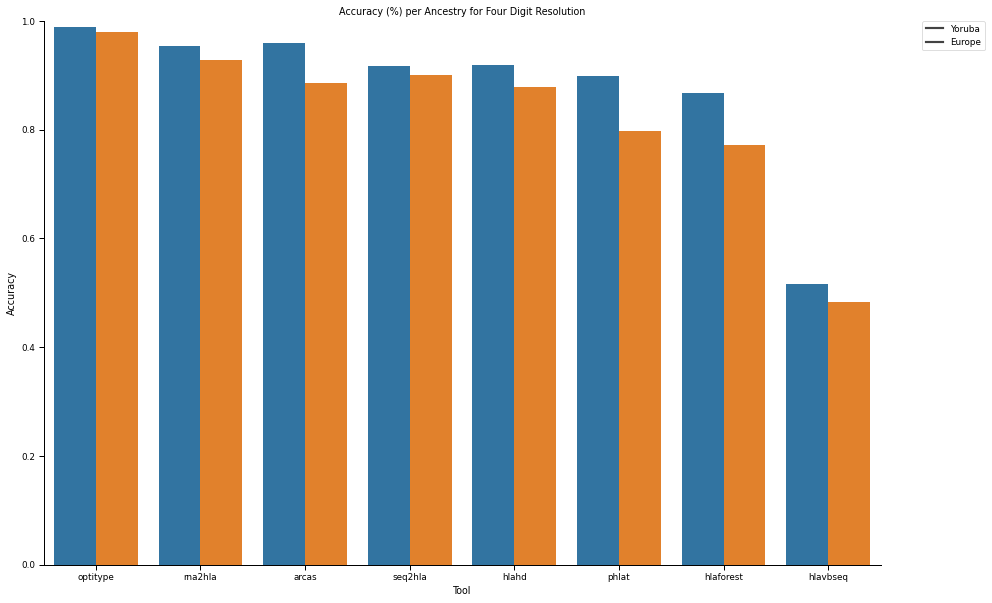

In [91]:
# 4 dig accuracy


df_accuracy=pd.concat([df['tool'],dfeuro4dig,dfyoru4dig],axis=1, join='inner')

df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)

tool_names=['OptiType','ArcasHLA','RNA2HLA','HLAForest','Seq2HLA','HLA-HD','PHLAT','HLA-VBseq']
order =["optitype","rna2hla","arcas","seq2hla","hlahd","phlat","hlaforest","hlavbseq"]

sns.set_context("paper")
sns.color_palette("pastel")
plt.figure(figsize=(15,10))
ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=order)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Tool")
ax.set_title("Accuracy (%) per Ancestry for Four Digit Resolution") 
plt.legend(labels=['Yoruba','Europe'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1))
sns.despine()
#plt.savefig('../Figures/read_length_accuracy_4dig.png',bbox_inches ="tight",dpi=300)

         tool                 ancestry  accuracy
0    optitype  europe two dig accuracy  0.994866
1       arcas  europe two dig accuracy  0.990768
2     rna2hla  europe two dig accuracy  0.979415
3   hlaforest  europe two dig accuracy  0.979021
4     seq2hla  europe two dig accuracy  0.971135
5       hlahd  europe two dig accuracy  0.939848
6       phlat  europe two dig accuracy  0.950865
7    hlavbseq  europe two dig accuracy  0.548786
8    optitype  yoruba two dig accuracy  1.000000
9       arcas  yoruba two dig accuracy  0.990536
10    rna2hla  yoruba two dig accuracy  0.974903
11  hlaforest  yoruba two dig accuracy  0.929795
12    seq2hla  yoruba two dig accuracy  0.958333
13      hlahd  yoruba two dig accuracy  0.955696
14      phlat  yoruba two dig accuracy  0.900709
15   hlavbseq  yoruba two dig accuracy  0.526230


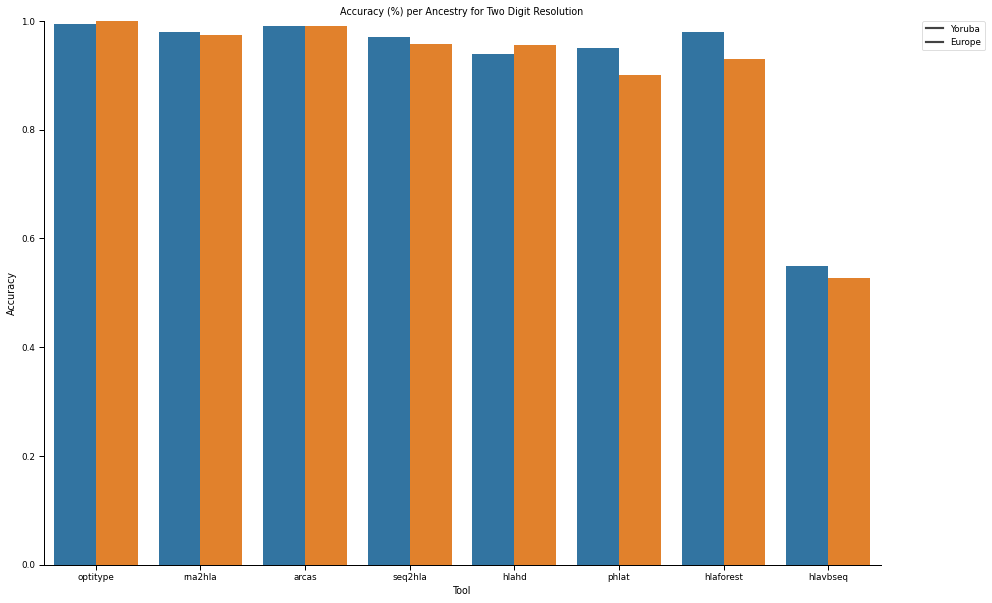

In [93]:
# 2 dig accuracy plot
df_accuracy=pd.concat([df['tool'],dfeuro2dig,dfyoru2dig],axis=1, join='inner')
df_accuracy = pd.melt(df_accuracy, id_vars="tool", var_name="ancestry", value_name="accuracy")
print(df_accuracy)

tool_names=['OptiType','ArcasHLA','RNA2HLA','HLAForest','Seq2HLA','HLA-HD','PHLAT','HLA-VBseq']
order =["optitype","rna2hla","arcas","seq2hla","hlahd","phlat","hlaforest","hlavbseq"]

sns.set_context("paper")
sns.color_palette("pastel")
plt.figure(figsize=(15,10))
ax=sns.barplot(x = 'tool', y = 'accuracy', data=df_accuracy,hue='ancestry',order=order)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Tool")
ax.set_title("Accuracy (%) per Ancestry for Two Digit Resolution") 
plt.legend(labels=['Yoruba','Europe'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1))
sns.despine()
#plt.savefig('../Figures/read_length_accuracy_4dig.png',bbox_inches ="tight",dpi=300)